In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from laplace_hdc_helper import load_dataset
from laplace_hdc_encoder import hdc_encoder
from laplace_hdc_classifier import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")

Using device:	cuda:0


### Hyperparameters

In [2]:
hyperdim = 10000 
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="binary_sgd"
epochs=3

## Load Data

In [3]:
class_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# load the MNIST training data
train_data = datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Load the MNIST testing data
test_data = datasets.MNIST(
    './',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

num_classes = len(class_names)

## Kernel Matrix Construction

lambda = 0.023098520934581757


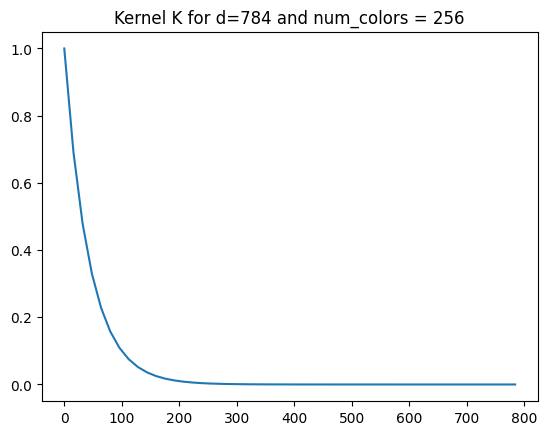

In [4]:
# Determining Lambda from random 1000 samples
batch_size = 100
num_colors = 256

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

## Create Encoder

In [5]:
encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
print(f"mode: {encoder_mode}\nHyperdimension: {encoder.hyperdim}")

mode: shift_1d
Hyperdimension: 10000


## Ecode Data

In [6]:
batch_size = 512
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

# Encode the data

t0 = time.time()
train_hdc = encoder.encode(train_loader)
t1 = time.time()

print(f"train encoding time: {t1 -t0}")

t0 = time.time()
test_hdc = encoder.encode(test_loader)
t1 = time.time()

print(f"test encoding time: {t1 -t0}")

train encoding time: 31.48933219909668
test encoding time: 5.089881896972656


## Classification

In [7]:
batch_size = 256
train_loader_hdc = DataLoader(
    train_hdc,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_hdc = DataLoader(
    test_hdc,
    batch_size=batch_size,
    shuffle=True,
)

model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=epochs)
accuracy = test_hdc_classifier(model, test_loader_hdc)
print(f"mode: {classifier_mode} \ntest accuracy: {accuracy}")

100%|████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]

mode: binary_sgd 
test accuracy: 0.946
